In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
legend_properties = {'weight':'bold'}

In [2]:
import os
import pickle

base_folder = r"E:\data\dao-0310-23\V4_4\Turbulence_Grid_4"

frequencies = [50, 100, 150, 200, 250, 300]
intensities = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40"]

# the file stubs to read (without folder prefix)
file_stubs = [
    "dao_performance_across_turbulence_time",
    "hierarchy_performance_across_turbulence_time",
    "autonomy_performance_across_turbulence_time",
    "dao_diversity_across_turbulence_time",
    "hierarchy_diversity_across_turbulence_time",
    "autonomy_diversity_across_turbulence_time",
    "dao_variance_across_turbulence_time",
    "hierarchy_variance_across_turbulence_time",
    "autonomy_variance_across_turbulence_time"
]

# store results in nested dict: results[frequency][intensity][filename]
results = {}

for f in frequencies:
    results[f] = {}
    for i in intensities:
        folder = os.path.join(base_folder, f"Turbulence_{f}_{i}")
        data_dict = {}
        for stub in file_stubs:
            file_path = os.path.join(folder, stub)
            with open(file_path, 'rb') as infile:
                data_dict[stub] = pickle.load(infile)
        results[f][i] = data_dict


In [3]:
import os
import pickle
import numpy as np
import pandas as pd

# fraction of the horizon to treat as "end-state"
k = 0.20  # last 20%; change as needed

# --- Helper ---
def long_term_gap_tail(dao_list, hier_list, tail_frac=0.20):
    dao = np.asarray(dao_list, dtype=float)
    hier = np.asarray(hier_list, dtype=float)
    if len(dao) != len(hier):
        raise ValueError(f"Length mismatch: DAO={len(dao)} vs HIER={len(hier)}")

    n = len(dao)
    if n == 0:
        raise ValueError("Empty performance lists")

    # guard for very short series
    tail_len = max(1, int(round(tail_frac * n)))
    tail_start = n - tail_len

    return float(np.mean(dao[tail_start:] - hier[tail_start:]))

# --- Compute gaps for each folder ---
gaps_nested = {}      # gaps_nested[freq][intensity] = value
rows = []             # tidy rows for CSV/DF

for f in frequencies:
    gaps_nested[f] = {}
    for i in intensities:
        folder = os.path.join(base_folder, f"Turbulence_{f}_{i}")

        # Only the two files we need
        dao_path  = os.path.join(folder, "dao_performance_across_turbulence_time")
        hier_path = os.path.join(folder, "hierarchy_performance_across_turbulence_time")

        # Read
        try:
            with open(dao_path,  'rb') as f_dao, open(hier_path, 'rb') as f_hier:
                dao_perf  = pickle.load(f_dao)
                hier_perf = pickle.load(f_hier)

            gap = long_term_gap_tail(dao_perf, hier_perf, tail_frac=k)
            gaps_nested[f][i] = gap
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": gap})

        except FileNotFoundError as e:
            # Record NaN if a folder/file is missing
            gaps_nested[f][i] = np.nan
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": np.nan})
            print(f"[WARN] Missing file in {folder}: {e.filename}")
        except Exception as e:
            # Record NaN on any other error but keep going
            gaps_nested[f][i] = np.nan
            rows.append({"frequency": f, "intensity": float(i), "k_tail": k, "long_term_gap_DAO_minus_Hier": np.nan})
            print(f"[WARN] Error computing gap for {folder}: {e}")

# --- Save results ---
# 1) Tidy CSV for quick inspection in Excel/R/Python
out_csv = os.path.join(f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.csv")
pd.DataFrame(rows).sort_values(["frequency", "intensity"]).to_csv(out_csv, index=False)

# 2) Pickle the nested dict (freq -> intensity -> gap)
out_pkl = os.path.join(f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.pkl")
with open(out_pkl, "wb") as f_out:
    pickle.dump(gaps_nested, f_out)

print(f"Saved:\n  - {out_csv}\n  - {out_pkl}")

# (Optional) quick peek
df_preview = pd.DataFrame(rows).sort_values(["frequency", "intensity"])
print(df_preview.head(10))

Saved:
  - long_term_gap_DAO_minus_Hierarchy_tail_20pct.csv
  - long_term_gap_DAO_minus_Hierarchy_tail_20pct.pkl
   frequency  intensity  k_tail  long_term_gap_DAO_minus_Hier
0         50       0.05     0.2                      0.004038
1         50       0.10     0.2                      0.004367
2         50       0.15     0.2                      0.002793
3         50       0.20     0.2                      0.000110
4         50       0.25     0.2                      0.000202
5         50       0.30     0.2                      0.000884
6         50       0.35     0.2                      0.000124
7         50       0.40     0.2                      0.000663
8        100       0.05     0.2                     -0.002618
9        100       0.10     0.2                      0.006580


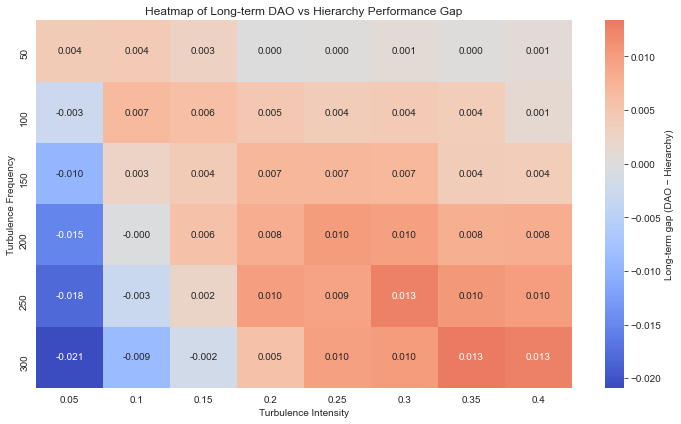

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV if needed
out_csv = f"long_term_gap_DAO_minus_Hierarchy_tail_{int(k*100)}pct.csv"
df = pd.read_csv(out_csv)

# Make sure intensity is numeric for sorting
df["intensity"] = df["intensity"].astype(float)

# Pivot into matrix: rows = frequency, cols = intensity
heatmap_data = df.pivot(index="frequency", columns="intensity", values="long_term_gap_DAO_minus_Hier")

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={'label': 'Long-term gap (DAO − Hierarchy)'}
)

plt.title("Heatmap of Long-term DAO vs Hierarchy Performance Gap")
plt.xlabel("Turbulence Intensity")
plt.ylabel("Turbulence Frequency")
plt.tight_layout()
plt.show()


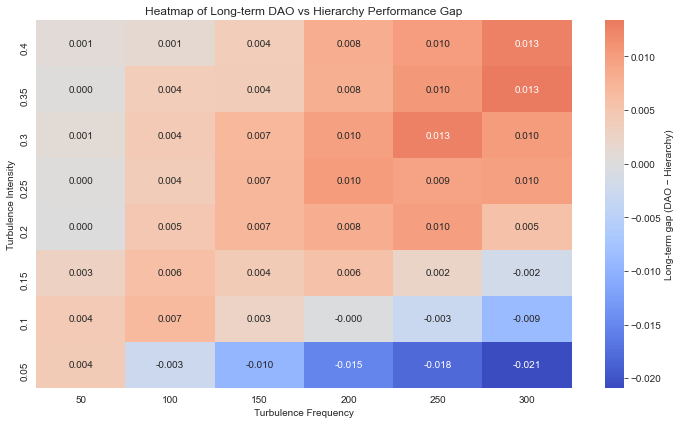

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numeric type for sorting
df["intensity"] = df["intensity"].astype(float)

# Pivot with intensities as rows
heatmap_data = df.pivot(index="intensity", columns="frequency", values="long_term_gap_DAO_minus_Hier")

# Reindex to enforce ascending intensity
heatmap_data = heatmap_data.sort_index(ascending=True)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={'label': 'Long-term gap (DAO − Hierarchy)'}
)

plt.title("Heatmap of Long-term DAO vs Hierarchy Performance Gap")
plt.xlabel("Turbulence Frequency")
plt.ylabel("Turbulence Intensity")

# Flip so that small intensities are at the bottom
ax.invert_yaxis()

plt.tight_layout()
plt.show()


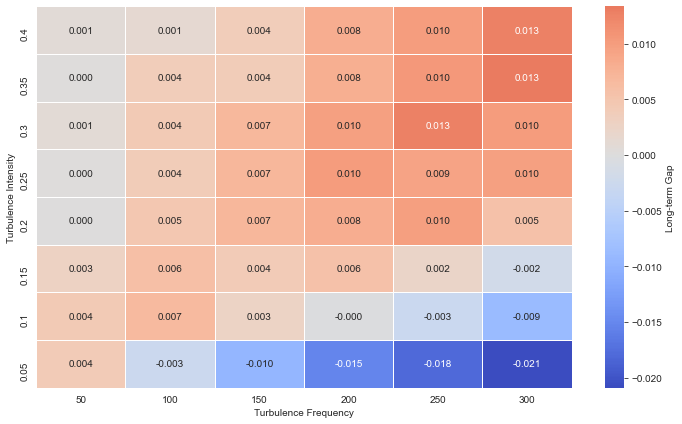

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure numeric type for sorting
df["intensity"] = df["intensity"].astype(float)

# --- build numeric matrix for colormap ---
heatmap_data = df.pivot(index="intensity", columns="frequency",
                        values="long_term_gap_DAO_minus_Hier").sort_index(ascending=True)

# --- build annotation strings: number + stars ---
def stars_from_p(p):
    if pd.isna(p):
        return ""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# If p_value not present, create empty stars (won't crash)
if "p_value" not in df.columns:
    df["p_value"] = np.nan

df["annot_text"] = df.apply(
    lambda r: (f"{r['long_term_gap_DAO_minus_Hier']:.3f}{stars_from_p(r['p_value'])}"
               if pd.notna(r['long_term_gap_DAO_minus_Hier']) else ""),
    axis=1
)

annot_data = df.pivot(index="intensity", columns="frequency", values="annot_text")
# align annotation matrix with heatmap_data in case of missing cells or ordering
annot_data = annot_data.reindex(index=heatmap_data.index, columns=heatmap_data.columns)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=annot_data,    # pass the formatted strings
    fmt="",              # strings already formatted
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Long-term Gap'},
    # Optional: thin gridlines make reading easier
    linewidths=0.5, linecolor="white"
)

# plt.title("Heatmap of Long-term DAO vs Hierarchy Performance Gap")
plt.xlabel("Turbulence Frequency")
plt.ylabel("Turbulence Intensity")

# Flip so that small intensities are at the bottom
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(base_folder + r"\DAO_Hierarchy_performance_gap", transparent=True, dpi=300)
plt.show()


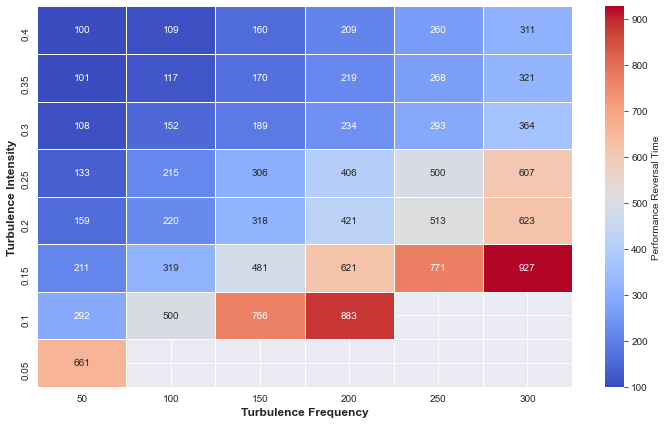

In [7]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------------
# Your existing setup
# ----------------------------
base_folder = r"E:\data\dao-0310-23\V4_4\Turbulence_Grid_4"
frequencies = [50, 100, 150, 200, 250, 300]
intensities = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40"]

# ----------------------------
# Helper: find first intersection time
# ----------------------------
def _to_series(x):
    """Accepts 1D (T,) or 2D (R,T). Returns 1D (T,) by averaging runs if needed."""
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        return x
    if x.ndim == 2:
        return np.nanmean(x, axis=0)
    raise ValueError(f"Unsupported ndim={x.ndim}")

def first_intersection_time(dao, hier):
    """
    Return the first time index (possibly fractional) where dao(t) == hier(t).
    Returns np.nan if no crossing exists.
    """
    dao = _to_series(dao)
    hier = _to_series(hier)
    if dao.shape != hier.shape:
        raise ValueError(f"Shape mismatch: DAO{dao.shape} vs HIER{hier.shape}")
    T = len(dao)
    if T < 2:
        return np.nan

    diff = dao - hier

    # Exact tie?
    exact_ties = np.where(np.isfinite(diff) & (diff == 0))[0]
    if exact_ties.size > 0:
        return float(exact_ties[0])

    # Scan for first sign change
    for t in range(1, T):
        d_prev, d_curr = diff[t-1], diff[t]
        if not (np.isfinite(d_prev) and np.isfinite(d_curr)):
            continue
        if d_prev * d_curr < 0:  # sign change
            alpha = -d_prev / (d_curr - d_prev) if d_curr != d_prev else 0.5
            alpha = float(np.clip(alpha, 0.0, 1.0))
            return (t - 1) + alpha

    return np.nan  # no crossing

# ----------------------------
# Compute intersections
# ----------------------------
rows = []
for f in frequencies:
    for i in intensities:
        folder = os.path.join(base_folder, f"Turbulence_{f}_{i}")
        dao_path  = os.path.join(folder, "dao_performance_across_turbulence_time")
        hier_path = os.path.join(folder, "hierarchy_performance_across_turbulence_time")
        try:
            with open(dao_path, "rb") as fd, open(hier_path, "rb") as fh:
                dao_perf  = pickle.load(fd)
                hier_perf = pickle.load(fh)

            t_star = first_intersection_time(dao_perf, hier_perf)
            rows.append({
                "frequency": f,
                "intensity": float(i),
                "t_intersect": t_star
            })
        except FileNotFoundError as e:
            rows.append({"frequency": f, "intensity": float(i), "t_intersect": np.nan})
            print(f"[WARN] Missing file in {folder}: {e.filename}")
        except Exception as e:
            rows.append({"frequency": f, "intensity": float(i), "t_intersect": np.nan})
            print(f"[WARN] Error at {folder}: {e}")

df_intersections = pd.DataFrame(rows)

# ----------------------------
# Heatmap of t_intersect
# ----------------------------
heatmap_t = df_intersections.pivot(index="intensity", columns="frequency", values="t_intersect")
heatmap_t = heatmap_t.sort_index(ascending=True)

# Format annotations: show integer (or 1 decimal) time
annot_mat = heatmap_t.applymap(lambda v: f"{v:.0f}" if pd.notna(v) else "")

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_t,
    annot=annot_mat,  # only show time
    fmt="",           # already formatted
    cmap="coolwarm",
    cbar_kws={'label': 'Performance Reversal Time'},
    linewidths=0.5, linecolor="white"
)

# Create colormap with NaN color set to gray
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color="lightgray")  # or "dimgray" / "silver"

# plt.title("Heatmap of First DAO–Hierarchy Intersection Time")
plt.xlabel('Turbulence Frequency', fontweight='bold', fontsize=12)
plt.ylabel('Turbulence Intensity', fontweight='bold', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(base_folder + r"\DAO_Hierarchy_intersection_time", transparent=True, dpi=300)
plt.show()


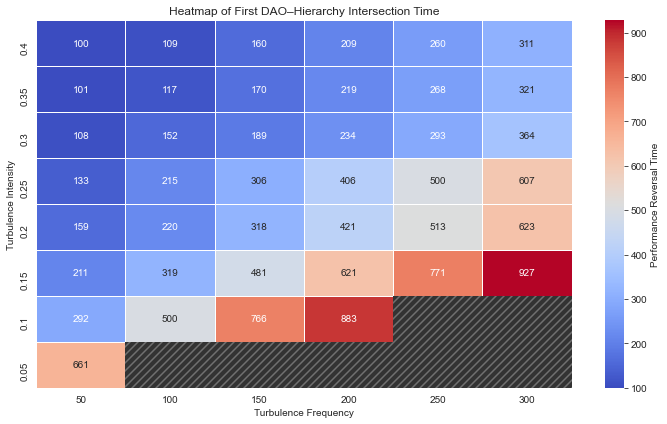

In [8]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import matplotlib as mpl

# ----------------------------
# Your existing setup
# ----------------------------
# base_folder = r"E:\data\dao-0310-23\V4_4\Turbulence_Grid_4"
# frequencies = [50, 100, 150, 200, 250, 300]
# intensities = ["0.05", "0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40"]

# ... (first_intersection_time helper + data loading that builds df_intersections) ...

# ----------------------------
# Heatmap of t_intersect
# ----------------------------
# Make hatch lines thicker globally
mpl.rcParams['hatch.linewidth'] = 2.0   # default is 1.0

heatmap_t = df_intersections.pivot(index="intensity", columns="frequency", values="t_intersect")
heatmap_t = heatmap_t.sort_index(ascending=True)

# Annotations: only time (integer) where available
annot_mat = heatmap_t.applymap(lambda v: f"{v:.0f}" if pd.notna(v) else "")

# Colormap with a very light NaN color (so hatch shows clearly)
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color=(0.92, 0.92, 0.92, 0.3))  # light gray, slight transparency

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_t,
    annot=annot_mat,
    fmt="",
    cmap=cmap,
    cbar_kws={'label': "Performance Reversal Time"},
    linewidths=0.5, linecolor="white"
)

plt.title("Heatmap of First DAO–Hierarchy Intersection Time")
plt.xlabel("Turbulence Frequency")
plt.ylabel("Turbulence Intensity")

# Invert so small intensities at the bottom (as you prefer)
ax.invert_yaxis()

# ---- NEW: hatch overlay for NaN cells ----
nan_mask = heatmap_t.isna().values
nrows, ncols = nan_mask.shape

# Make hatch lines thicker (optional but helps)
mpl.rcParams['hatch.linewidth'] = 1.5  # was 2.0

# ---- Hatch overlay for NaN cells ----
nan_mask = heatmap_t.isna().values
nrows, ncols = nan_mask.shape

for r in range(nrows):
    for c in range(ncols):
        if nan_mask[r, c]:
            ax.add_patch(
                Rectangle(
                    (c, r), 1, 1,
                    facecolor=(0.2, 0.2, 0.2, 1.0),   # deep, opaque gray
                    edgecolor=(0.6, 0.6, 0.6, 0.6),   # WHITE edge -> hatch color
                    hatch="///",                      # keep your pattern
                    linewidth=0.0,                    # border off; hatch still shows
                    zorder=3                          # above heatmap, below text
                )
            )

# Legend patch for "No intersection"
no_int_patch = Patch(facecolor=(0.7,0.7,0.7),
                     edgecolor="black", hatch="xxxx",
                     label="")
# ax.legend(handles=[no_int_patch], loc='upper left',
#           bbox_to_anchor=(1.02, 1.0), frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(base_folder, "DAO_Hierarchy_intersection_time_hatched.png"),
            transparent=True, dpi=300)
plt.show()


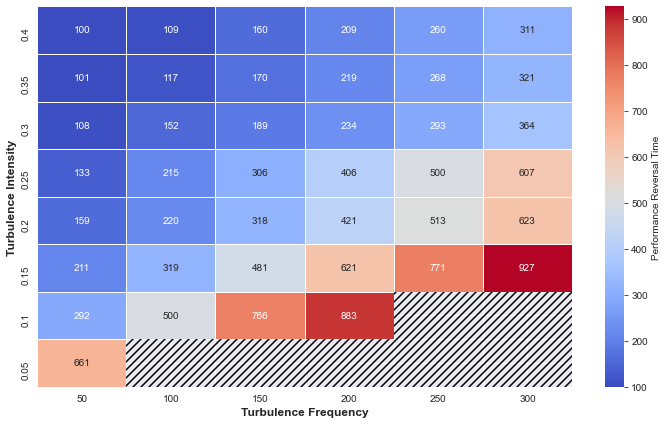

In [11]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# ----------------------------
# Your existing setup (same as before)
# ----------------------------

# ... your data loading and df_intersections creation code ...

# ----------------------------
# Heatmap of t_intersect
# ----------------------------
heatmap_t = df_intersections.pivot(index="intensity", columns="frequency", values="t_intersect")
heatmap_t = heatmap_t.sort_index(ascending=True)

# Format annotations: show integer (or 1 decimal) time
annot_mat = heatmap_t.applymap(lambda v: f"{v:.0f}" if pd.notna(v) else "")

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_t,
    annot=annot_mat,  # only show time
    fmt="",           # already formatted
    cmap="coolwarm",
    cbar_kws={'label': 'Performance Reversal Time'},
    linewidths=0.5, linecolor="white"
)

# Overlay hatched rectangles for NaN cells
for i, intensity in enumerate(heatmap_t.index):
    for j, freq in enumerate(heatmap_t.columns):
        if pd.isna(heatmap_t.loc[intensity, freq]):
            ax.add_patch(Rectangle(
                (j, i), 1, 1,               # (x, y), width, height
                fill=False,                 # don't fill, just hatch
                hatch='///',                # choose hatch style
                edgecolor='black',          # border color
                linewidth=0.0               # no border line
            ))

# plt.title("Heatmap of First DAO–Hierarchy Intersection Time")
plt.xlabel('Turbulence Frequency', fontweight='bold', fontsize=12)
plt.ylabel('Turbulence Intensity', fontweight='bold', fontsize=12)

ax.invert_yaxis()
plt.tight_layout()
plt.savefig(base_folder + r"\DAO_Hierarchy_intersection_time_hatched.png", transparent=True, dpi=300)
plt.show()
